In [2]:
import gc
import glob
import json
from multiprocessing import Process, Queue
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7877895655734547617
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7969563179893211760
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2022-04-25 17:50:44.537895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 17:50:44.608458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 17:50:44.698783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 17:50:44.699632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
unique_symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y', '-']
label_mapper = {sym: index for index, sym in enumerate(unique_symbols)}
char_mapper = {sym: sym for sym in unique_symbols}
char_mapper['A'] = 'А'
char_mapper['B'] = 'В'
char_mapper['C'] = 'С'
char_mapper['E'] = 'Е'
char_mapper['H'] = 'Н'
char_mapper['K'] = 'К'
char_mapper['M'] = 'М'
char_mapper['O'] = 'О'
char_mapper['P'] = 'Р'
char_mapper['T'] = 'Т'
char_mapper['X'] = 'Х'
char_mapper['Y'] = 'У'
char_mapper['-'] = ''
heigth, width = 64, 256

In [4]:
def load_annotation(path, name):
    with open(path, 'r') as file:
        json_str = file.read()
        dct = json.loads(json_str)
    try:
        return dct['description']
    except Exception:
        return None


def prepare_image(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (width, heigth))
    img = np.array(img).tolist()
    return img


def prepare_label(ann, mapper):
    indexes = [mapper[ch] for ch in ann]
    if len(ann) < 9:
        indexes += [len(unique_symbols)-1]
    label = np.zeros((9, len(mapper)))
    label[np.arange(9), indexes] = 1
    return label.tolist()


def prepare_dataset(name, unique_symbols=None):
    images = sorted(
        glob.glob(f'/kaggle/input/runumberplatedataset/autoriaNumberplateOcrRu-2021-09-01/{name}/img/*.png'))
    jsons = sorted(
        glob.glob(f'/kaggle/input/runumberplatedataset/autoriaNumberplateOcrRu-2021-09-01/{name}/ann/*.json'))

    df = pd.DataFrame(list(zip(images, jsons)), columns=['image', 'annotation'])
    df['annotation'] = df['annotation'].apply(lambda path: load_annotation(path, name))
    df = df[df['annotation'].apply(lambda ann: ann is not None)]
    
    df = df.sample(frac=1).reset_index(drop=True)
    batches = len(df['annotation'].tolist()) // 128
    df = df.head(batches * 128)
    df.to_csv(f'/kaggle/working/{name}_labeled.csv', index=False, header=True)

    if unique_symbols is None:
        unique_symbols = set()
        for ann in df['annotation'].tolist():
            unique_symbols.update(set(ann))
        unique_symbols = sorted(list(unique_symbols))
        print(f"Unique symbols num: {len(unique_symbols)}")
        print(unique_symbols)

#     del df
#     gc.collect()

#     df_chunks = pd.read_csv(f'/kaggle/working/{name}_labeled.csv', chunksize=1000)
#     sym_mapper = {sym: index for index, sym in enumerate(unique_symbols)}
#     for step, df in enumerate(df_chunks):
#         print('begin loading images')
#         df['image'] = df['image'].apply(lambda img: prepare_image(img))
#         print('end loading images')
#         df['label'] = df['annotation'].apply(lambda ann: prepare_label(ann, sym_mapper))
#         print('end loading annotations')
#         df.to_csv(f'/kaggle/working/{name}.csv', index=False,
#                   header=True if step == 0 else False,
#                   mode='w' if step == 0 else 'a')

    return df, unique_symbols


# train, _ = prepare_dataset('train', unique_symbols)
# val, _ = prepare_dataset('val', unique_symbols)
# train.head(20)

In [ ]:
def show_samples(images, nums):
    plt.rcParams['figure.figsize'] = (20, 3)
    for i, img in enumerate(images):
        ax = plt.subplot(nums // 5 + min(0, nums % 5), 5, i + 1)
        ax.imshow(cv2.imread(img))
        plt.axis('off')


nums = 20
show_samples(train.tail(nums)['image'].tolist(), nums)
plt.show()

In [5]:
class ResBlock(tf.keras.layers.Layer):

    def __init__(self, filters, kernelsize, **kwargs):
        super().__init__(**kwargs)
        self._conv_1 = tf.keras.layers.Conv2D(filters, kernelsize, padding='same',
                                              kernel_initializer=tf.keras.initializers.HeUniform())
        self._relu_1 = tf.keras.layers.ReLU()
        self._conv_2 = tf.keras.layers.Conv2D(filters, kernelsize, padding='same',
                                              kernel_initializer=tf.keras.initializers.HeUniform())
        self._relu_2 = tf.keras.layers.ReLU()

    @tf.function
    def call(self, inputs, training=True):
        x = self._conv_1(inputs)
        x = self._relu_1(x)
        x = self._conv_2(x)
        x = x + inputs
        x = self._relu_2(x)
        return x


class BuildBlock(tf.keras.layers.Layer):

    def __init__(self, filters, kernelsize, padding='same', **kwargs):
        super().__init__(**kwargs)
        self._block = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters, kernelsize, padding='same',
                                              kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters, kernelsize, padding='same',
                                              kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization()
        ])

    @tf.function
    def call(self, inputs, training=True):
        return self._block(inputs, training)


class DownSampler(tf.keras.layers.Layer):

    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self._downsampler = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, (4, 4), strides=(2, 2), padding='same',
                                   kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])

    @tf.function
    def call(self, inputs, training=True):
        return self._downsampler(inputs, training)


class PositionalEncoder(tf.keras.layers.Layer):

    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self._encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, (3, 3), padding='same',
                                   kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters, (12, 1),
                                   kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])

    @tf.function
    def call(self, inputs, training=True):
        return self._encoder(inputs, training)


class LPFeatureExtractor(tf.keras.layers.Layer):

    def __init__(self, filters, kernelsize, **kwargs):
        super().__init__(**kwargs)
        self._extractor = tf.keras.Sequential([
            ResBlock(filters, kernelsize),
            ResBlock(filters, kernelsize),
            tf.keras.layers.Conv2D(filters, kernelsize, padding='same',
                                   kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])

    @tf.function
    def call(self, inputs, training=True):
        return self._extractor(inputs, training)


class Classifier(tf.keras.layers.Layer):

    def __init__(self, classes, **kwargs):
        super().__init__(**kwargs)
        self._classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(64, kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(128, kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(64, kernel_initializer=tf.keras.initializers.HeUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(classes, kernel_initializer=tf.keras.initializers.GlorotUniform()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Softmax()
        ])

    @tf.function
    def call(self, inputs, training=True):
        return self._classifier(inputs, training)


class SCRNet(tf.keras.Model):

    def __init__(self, output_chars, dict_size, **kwargs):
        super().__init__(**kwargs)
        
        self._preprocess = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1/255.0 * 2, -1.0),
            tf.keras.layers.Lambda(lambda t: tf.pad(t, tf.constant([[0, 0], [16, 16], [0, 0], [0, 0]]), 'CONSTANT')),
            tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.7), width_factor=(-0.1, 0.7), fill_mode='nearest'),
            tf.keras.layers.RandomRotation((-0.15, 0.15), fill_mode='nearest')
        ])
        
        # downsample the data by factor 2
        self._s_conv_1 = DownSampler(16)

        # stage 1
        blocks = [BuildBlock(63, (3, 3)) for i in range(4)]
        self._stage_1 = tf.keras.Sequential(blocks)
        self._ds_1 = DownSampler(63)

        # stage 2
        blocks = [BuildBlock(97, (3, 3)) for i in range(4)]
        self._stage_2 = tf.keras.Sequential(blocks)
        self._ds_2 = DownSampler(97)

        # stage 3
        blocks = [BuildBlock(128, (3, 3)) for i in range(4)]
        self._stage_3 = tf.keras.Sequential(blocks)
        self._pe = PositionalEncoder(128)

        # stage 4'
        self._stage_4 = tf.keras.Sequential([LPFeatureExtractor(128, (1, 3)) for i in range(2)] \
                                            + [tf.keras.layers.Flatten(), tf.keras.layers.BatchNormalization(), tf.keras.layers.ReLU()])

        # classifiers: 6 classifiers for letters and 3 for regions
        self._classifiers = [Classifier(dict_size) for i in range(output_chars)]

    @tf.function
    def call(self, inputs, training=True):
        
        x = self._preprocess(inputs, training)
        
        x = self._s_conv_1(x, training)

        x = self._stage_1(x, training)
        x = self._ds_1(x, training)

        x = self._stage_2(x, training)
        x = self._ds_2(x, training)

        x = self._stage_3(x, training)
        x = self._pe(x, training)

        x = self._stage_4(x, training)

        # produces tensor (batch_size, 9 symbols, |Alphabet|)
        x = tf.concat([tf.expand_dims(classifier(x, training), 1) for classifier in self._classifiers], axis=1)

        return x
    
    @tf.function
    def preprocess_image(self, tensor, training=True):
        return self._preprocess(tensor, training)
    
    @tf.function
    def get_reg_weights_norm(self):
        weights = []
        weights.extend(self._stage_1.trainable_weights)
        weights.extend(self._stage_2.trainable_weights)
        weights.extend(self._stage_3.trainable_weights)
        return tf.reduce_sum([tf.reduce_sum(tf.abs(w)) for w in weights])
        
        

In [35]:
batch_size = 128
epochs = 10
lr = 1e-3
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [37]:
class LicensePlateAccuracy(tf.keras.metrics.Accuracy):

    def __init__(self, name='lp_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self._means = []

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        labels = tf.math.argmax(y_true, -1)
        logits = tf.math.argmax(y_pred, -1)
        equals = tf.cast(tf.math.equal(tf.reduce_sum(tf.cast(tf.math.equal(labels, logits), tf.int32), axis=-1), 9), tf.float32)
        self._means.append(tf.reduce_mean(equals))
#         super().update_state(tf.ones_like(equals, tf.int8), equals)
    
#     @tf.function
    def result(self):
        return np.mean([np.array(tensor) for tensor in self._means])
    
#     @tf.function
    def reset_states(self):
        self._means = []
    
def lp_accuracy(y_true, y_pred):
    labels = tf.math.argmax(y_true, -1)
    logits = tf.math.argmax(y_pred, -1)
    return tf.cast(tf.math.equal(tf.constant(9), tf.reduce_sum(tf.cast(tf.math.equal(labels, logits), tf.int32), axis=-1)), tf.float32)

In [38]:
!cp -f /kaggle/input/runumberplates-meta/train_labeled.csv /kaggle/working/train_labeled.csv
!cp -f /kaggle/input/runumberplates-meta/val_labeled.csv /kaggle/working/val_labeled.csv

In [39]:
train_lines = sum(1 for row in open(f'./train_labeled.csv', 'r'))
train_batches = train_lines // batch_size + min(1, train_lines % batch_size)
print(f'Train batches - {train_batches}')

valid_lines = sum(1 for row in open(f'./val_labeled.csv', 'r'))
valid_batches = valid_lines // batch_size + min(1, valid_lines % batch_size)
print(f'Valid batches - {valid_batches}')

Train batches - 386
Valid batches - 39


In [40]:
def prepare_batch(df):
    print('load json data')
    df['image'] = df['image'].apply(lambda arr: np.array(json.loads(arr)) / 255.0 * 2 - 1.0)
    df['label'] = df['label'].apply(lambda arr: np.array(json.loads(arr)))
    print('convert to tensors')
    X = tf.convert_to_tensor(df['image'].tolist(), tf.float32)
    y = tf.convert_to_tensor(df['label'].tolist(), tf.float32)
    return X, y


# @tf.function
def train_step(X, y, model, loss_fn, optimizer, metrics):
    with tf.GradientTape() as tape:
#         preds, y = tf.cast(model(X, training=True), tf.float32), tf.cast(y, tf.float32)
#         preds, y = tf.clip_by_norm(preds, 1, axes=[-1]), tf.clip_by_norm(y, 1, axes=[-1])
#         preds, y = tf.clip_by_value(preds, 0.001, 1), tf.clip_by_value(y, 0, 1)
#         loss = tf.clip_by_value(loss_fn(y, preds) + 1e-4 * model.get_reg_weights_norm(), 0, 1e4)
        preds = model(X, training=True)
        loss = loss_fn(y, preds) + 1e-4 * model.get_reg_weights_norm()
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    for metric in metrics:
        metric.update_state(y, preds)
    return loss, preds


# @tf.function
def test_step(X, y, model, loss_fn, metrics):
#     preds, y = tf.cast(model(X, training=True), tf.float32), tf.cast(y, tf.float32)
#     preds, y = tf.clip_by_norm(preds, 1, axes=[-1]), tf.clip_by_norm(y, 1, axes=[-1])
#     preds, y = tf.clip_by_value(preds, 0.001, 1), tf.clip_by_value(y, 0, 1)
#     loss = tf.clip_by_value(loss_fn(y, preds) + 1e-4 * model.get_reg_weights_norm(), 0, 1e4)
    preds = model(X, training=False)
    loss = loss_fn(y, preds) + 1e-4 * model.get_reg_weights_norm()
    for metric in metrics:
        metric.update_state(y, preds)
    return loss


def early_stopping_callback(losses, patience=3, eps=1e-4):
    if len(losses) < 3:
        return False
    mean = np.mean(np.array(losses[-patience:]))
    matches = sum([1 if abs(mean - loss) < eps else 0 for loss in losses[-patience:]])
    return matches == patience

def fill_queue(q, it):
    while True:
        if q.qsize() < 30:
            try:
                batch = it.next()
            except Exception:
                continue
            X = batch[0]
            y = [prepare_label(ann, label_mapper) for ann in batch[1].tolist()]

            q.put((X, y))
        else:
            time.sleep(1)

In [41]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
# rescale=1./255, zoom_range=[0.8, 1.7], brightness_range=[0.0, 0.2], rotation_range=20

train_labeled = pd.read_csv('/kaggle/working/train_labeled.csv')
train_ds = tf.data.Dataset.from_generator(lambda: train_gen.flow_from_dataframe(train_labeled, x_col='image', y_col='annotation', target_size=(heigth, width), batch_size=batch_size, class_mode='raw'),
                                    output_signature=(
                                         tf.TensorSpec(shape=(batch_size, heigth, width, 3), dtype=tf.float32),
                                         tf.TensorSpec(shape=(batch_size), dtype=tf.string))).repeat(epochs).prefetch(tf.data.AUTOTUNE)

val_labeled = pd.read_csv('/kaggle/working/val_labeled.csv')
val_ds = tf.data.Dataset.from_generator(lambda: val_gen.flow_from_dataframe(val_labeled, x_col='image', y_col='annotation', target_size=(heigth, width), batch_size=batch_size, class_mode='raw'),
                                    output_signature=(
                                         tf.TensorSpec(shape=(batch_size, heigth, width, 3), dtype=tf.float32),
                                         tf.TensorSpec(shape=(batch_size), dtype=tf.string))).repeat(epochs).prefetch(tf.data.AUTOTUNE)

table = tf.lookup.StaticVocabularyTable(
        tf.lookup.KeyValueTensorInitializer(
            list(label_mapper.keys()),
            list(label_mapper.values()),
            key_dtype=tf.string,
            value_dtype=tf.int64,
        ),
        num_oov_buckets=1,
    )

# @tf.function
def make_label(val, ann):
    lbl = tf.strings.join([ann, '-'])
    lbl = tf.strings.substr(lbl, 0, 9)
    lbl = tf.strings.unicode_split(lbl, input_encoding='UTF-8').to_tensor(shape=(batch_size, 9))
    lbl = table.lookup(lbl)
    lbl = tf.one_hot(lbl, len(unique_symbols))
    return val, lbl

train_ds = train_ds.map(lambda val, lbl: make_label(val, lbl), num_parallel_calls=8)
val_ds = val_ds.map(lambda val, lbl: make_label(val, lbl), num_parallel_calls=8)
train_it = train_ds.as_numpy_iterator()
val_it = val_ds.as_numpy_iterator()

In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}
best_loss = 1e6

model = SCRNet(9, len(unique_symbols))
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=10.0)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, axis=-1)
model.build(input_shape=(None, heigth, width, 3))
model.summary()

# model.load_weights('/kaggle/input/scr-weights-v1/kaggle/working/best_scr_weights')

# gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                       rotation_range=20,
#                                                       width_shift_range=0.2,
#                                                       height_shift_range=0.2
#                                                      )


# train_labeled = pd.read_csv('/kaggle/working/train_labeled.csv')
# train_ds = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, zoom_range=[1.2,1.7], rotation_range=20).flow_from_dataframe(train_labeled, x_col='image', y_col='annotation', target_size=(heigth, width), batch_size=batch_size, class_mode='raw')

# train_queue = Queue(
# train_processes = [Process(target=fill_queue, args=(train_queue, train_ds)) for pid in range(4)]
# for process in train_processes:
#     process.start()


# val_labeled =  pd.read_csv('/kaggle/working/val_labeled.csv')
# val_ds = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, zoom_range=[1.2,1.7], rotation_range=20).flow_from_dataframe(val_labeled, x_col='image', y_col='annotation', target_size=(heigth, width), batch_size=batch_size, class_mode='raw')
# val_queue = Queue()
# val_processes = [Process(target=fill_queue, args=(val_queue, val_ds)) for pid in range(2)]
# for process in val_processes:
#     process.start()
metrics = [tf.keras.metrics.MeanMetricWrapper(fn=lp_accuracy, name='lp_accuracy')]
for epoch in range(epochs):
    print(f"\n Starting {epoch + 1} epoch")
    
    losses = []
    for step in range(train_batches):
        
        batch = train_it.next()
        X = tf.convert_to_tensor(batch[0])
        y = tf.convert_to_tensor(batch[1])
#         y = np.array([prepare_label(ann, label_mapper) for ann in batch[1].tolist()])
#         assert not np.any(np.isnan(X))
#         assert not np.any(np.isnan(y))
#         X, y = train_queue.get()
#         X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        
        loss, preds = train_step(X, y, model, loss_fn, optimizer, metrics)
        losses.append(float(loss))
        
        if (step % 100 == 0) or (step == train_batches - 1):
            print(f'--- Processed {step + 1} steps of {train_batches} current batch loss - {loss:.4f}')

    train_loss = float(np.mean(np.array(losses)))
    print(f"Train loss after {epoch + 1} epochs - {train_loss:.4f}")
    history['train_loss'].append(train_loss)

    for metric in metrics:
        value = metric.result()
        print(f'Train {metric.name}: {value:.4f}')
        key = f'train_{metric.name}'
        if key in history:
            history[key].append(value)
        else:
            history[key] = [value]
        metric.reset_states()

    losses = []
    for step in range(valid_batches):
        batch = val_it.next()
        X = tf.convert_to_tensor(batch[0])
        y = tf.convert_to_tensor(batch[1])
#         y = np.array([prepare_label(ann, label_mapper) for ann in batch[1].tolist()])
#         assert not np.any(np.isnan(X))
#         assert not np.any(np.isnan(y))
#         X, y = val_queue.get()
#         X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
        loss = test_step(X, y, model, loss_fn, metrics)
        losses.append(float(loss))

    val_loss = float(np.mean(np.array(losses)))
    print(f"Validation loss after {epoch + 1} epochs - {val_loss:.4f}")
    history['val_loss'].append(val_loss)

    for metric in metrics:
        value = metric.result()
        print(f'Valid {metric.name}: {value:.4f}')
        key = f'valid_{metric.name}'
        if key in history:
            history[key].append(value)
        else:
            history[key] = [value]
        metric.reset_states()

    if val_loss < best_loss:
        best_loss = val_loss
        model.save_weights('/kaggle/working/best_scr_weights')
        model.save('/kaggle/working/best_scr')

    losses = history['val_loss']
    if early_stopping_callback(losses):
        break
        
# for process in train_processes:
#     process.terminate()

# for process in val_processes:
#     process.terminate()

for key in history.keys():
    history[key] = [float(val) for val in history[key]]
    
model.load_weights('/kaggle/working/best_scr_weights')
best_acc  = max(history['valid_lp_accuracy'])
print(f'Best achieved validation accuracy - {best_acc:.4f}')
with open('history.json', 'w') as file:
    json.dump(history, file)

In [33]:
!zip scr.zip /kaggle/working/*

  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/best_scr/ (stored 0%)
  adding: kaggle/working/best_scr_weights.data-00000-of-00001 (deflated 20%)
  adding: kaggle/working/best_scr_weights.index (deflated 82%)
  adding: kaggle/working/checkpoint (deflated 39%)
  adding: kaggle/working/history.json (deflated 60%)
  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/test_labeled.csv (deflated 91%)
  adding: kaggle/working/train_labeled.csv (deflated 91%)
  adding: kaggle/working/val_labeled.csv (deflated 91%)


In [ ]:
del model, val, train, history
gc.collect()

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32) 
  return tf.image.resize(img, [heigth, width]) 
    
train = pd.read_csv('/kaggle/working/train_labeled.csv')
images = train['image'].apply(lambda img: decode_img(tf.io.read_file(img))).tolist()

In [42]:
model = SCRNet(9, len(unique_symbols))
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=10.0)
cce = tf.keras.losses.CategoricalCrossentropy(axis=-1)
# loss_fn = lambda y_true, y_pred: tf.clip_by_value(cce(tf.clip_by_value(tf.clip_by_norm(tf.cast(y_true, tf.float32), 1, axes=[-1]), 1e-3, 1), tf.clip_by_value(tf.clip_by_norm(tf.cast(y_pred, tf.float32), 1, axes=[-1]), 1e-3, 1)) + 1e-4 * model.get_reg_weights_norm(), 0, 1e4)
loss_fn = lambda y_true, y_pred: cce(y_true, y_pred) + 1e-4 * model.get_reg_weights_norm()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.MeanMetricWrapper(fn=lp_accuracy, name='lp_accuracy')])
model.build(input_shape=(None, heigth, width, 3))
model.summary()
model.load_weights('/kaggle/working/best_scr_weights')
# es = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-4,
#     patience=3,
#     restore_best_weights=True
# )
cp = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/models',
    monitor='val_loss',
    save_best_only=True
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=2,
    min_delta=0.001,
    min_lr=1e-6
)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, use_multiprocessing=True, workers=tf.data.AUTOTUNE, verbose='auto', max_queue_size=tf.data.AUTOTUNE,
         callbacks=[cp, rlr], steps_per_epoch=train_batches, validation_steps=valid_batches)

history = dict(history.history)
for key in history.keys():
    history[key] = [float(el) for el in history[key]]
        
with open('history.json', 'w') as file:
    json.dump(history, file)
model.save_weights('/kaggle/working/best_scr_weights')
model.save('/kaggle/working/best_scr')

Model: "scr_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 96, 256, 3)        0         
_________________________________________________________________
down_sampler_3 (DownSampler) multiple                  848       
_________________________________________________________________
sequential_38 (Sequential)   (None, 48, 128, 63)       262459    
_________________________________________________________________
down_sampler_4 (DownSampler) multiple                  63819     
_________________________________________________________________
sequential_44 (Sequential)   (None, 24, 64, 97)        653062    
_________________________________________________________________
down_sampler_5 (DownSampler) multiple                  151029    
_________________________________________________________________
sequential_50 (Sequential)   (None, 12, 32, 128)       11

In [ ]:
# model.save_weights('/kaggle/working/best_scr_weights')
model.save('/kaggle/working/best_scr')

In [57]:
!ls /kaggle/working/models/variables/variables

variables.data-00000-of-00001  variables.index


In [58]:
model.load_weights('/kaggle/working/models/variables/variables')

In [59]:
prepare_dataset('test', unique_symbols)

test_lines = sum(1 for row in open(f'./test_labeled.csv', 'r'))
test_batches = test_lines // batch_size + min(1, test_lines % batch_size)
print(f'Test samples - {test_lines}')
print(f'Test batches - {test_batches}')

Test samples - 2817
Test batches - 23


In [60]:
# evaluate solution on test data
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

test_labeled = pd.read_csv('/kaggle/working/val_labeled.csv')
test_ds = tf.data.Dataset.from_generator(lambda: test_gen.flow_from_dataframe(test_labeled, x_col='image', y_col='annotation', target_size=(heigth, width), batch_size=batch_size, class_mode='raw'),
                                    output_signature=(
                                         tf.TensorSpec(shape=(batch_size, heigth, width, 3), dtype=tf.float32),
                                         tf.TensorSpec(shape=(batch_size), dtype=tf.string))).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda val, lbl: make_label(val, lbl), num_parallel_calls=tf.data.AUTOTUNE)
test_it = test_ds.as_numpy_iterator()

images = []
losses = []
metrics = [tf.keras.metrics.MeanMetricWrapper(fn=lp_accuracy, name='lp_accuracy')]
acc = []
for step in range(test_batches):
    
    batch = test_it.next()
    X = batch[0]
    y = batch[1]
    
    pred = model(X, training=False).numpy()
    pred = [''.join([unique_symbols[i] for i in arr]) for arr in np.argmax(pred, axis=-1).tolist()]
    label = [''.join([unique_symbols[i] for i in arr]) for arr in np.argmax(y, axis=-1).tolist()]
    acc = np.mean([int(a == b) for a, b in zip(label, pred)])
    # transformed_image = (((model.preprocess_image(tf.convert_to_tensor(X))).numpy()[0] + 1) * 255.0 / 2).astype(np.int16)
#     y = np.array([prepare_label(ann, label_mapper) for ann in batch[1].tolist()])
    images.append((X[0].astype(np.int16), label[0], pred[0]))
    loss = test_step(tf.convert_to_tensor(X), tf.convert_to_tensor(y), model, loss_fn, metrics)
    losses.append(loss)
    print(f"Processed {step + 1} test steps of {test_batches}")

print(np.mean(acc))
test_loss = float(np.mean(np.array(losses)))
print(f"Test loss - {test_loss:.4f}")
for metric in metrics:
    value = metric.result()
    print(f"Test {metric.name}: {value:.4f}")
    metric.reset_states()

Found 4864 validated image filenames.
Processed 1 test steps of 23
Processed 2 test steps of 23
Processed 3 test steps of 23
Processed 4 test steps of 23
Processed 5 test steps of 23
Processed 6 test steps of 23
Processed 7 test steps of 23
Processed 8 test steps of 23
Processed 9 test steps of 23
Processed 10 test steps of 23
Processed 11 test steps of 23
Processed 12 test steps of 23
Processed 13 test steps of 23
Processed 14 test steps of 23
Processed 15 test steps of 23
Processed 16 test steps of 23
Processed 17 test steps of 23
Processed 18 test steps of 23
Processed 19 test steps of 23
Processed 20 test steps of 23
Processed 21 test steps of 23
Processed 22 test steps of 23
Processed 23 test steps of 23
0.9765625
Test loss - 0.2303
Test lp_accuracy: 0.9779


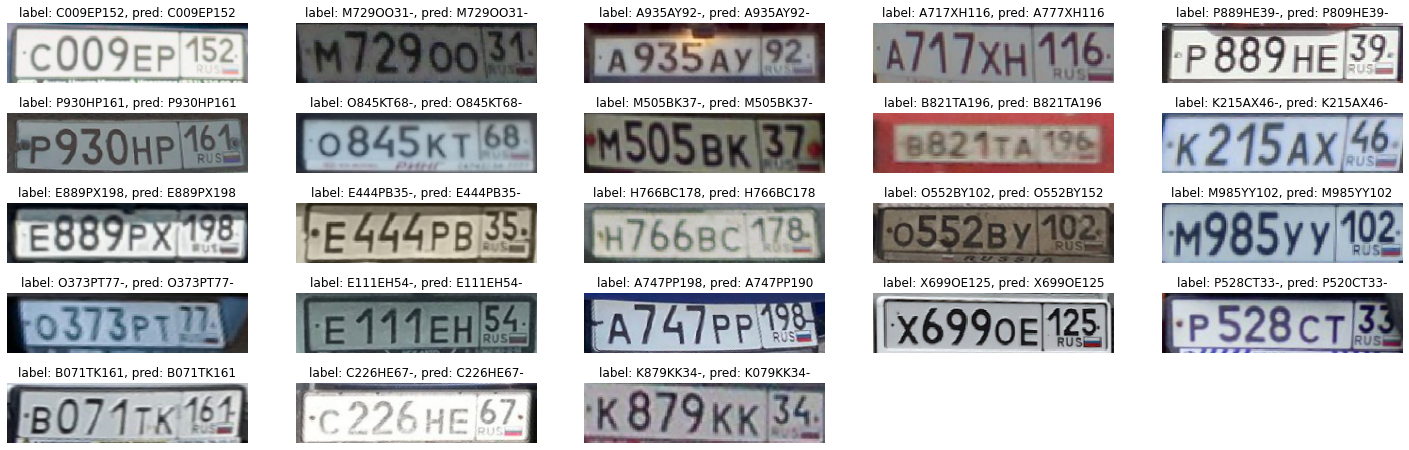

In [46]:
plt.rcParams['figure.figsize'] = (25, 8)
for index, tpl in enumerate(images):
    img, lbl, pred = tpl
    ax = plt.subplot(len(images) // 5 + min(1, len(images) % 5), 5, index+1)
    ax.imshow(img)
    plt.axis('off')
    plt.title(f'label: {lbl}, pred: {pred}')
plt.show()

In [ ]:
batch = test_it.next()
img = ((batch[0][0])*255).astype(np.int32) 
label = tf.argmax((batch[1][0]).astype(np.int32), -1).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()
logits = model(tf.expand_dims(tf.convert_to_tensor(img), 0), training=False)
pred = tf.argmax(logits, -1).numpy()[0]
print(''.join([unique_symbols[ind] for ind in pred]))
print(''.join([unique_symbols[ind] for ind in label]))

In [ ]:
from scipy.ndimage import zoom
def zoom_out(img, zoom_factor):
    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    # Bounding box of the zoomed-in region within the input array
    zh = int(np.round(h / zoom_factor))
    zw = int(np.round(w / zoom_factor))
    top = (h - zh) // 2
    left = (w - zw) // 2

    out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)

    # `out` might still be slightly larger than `img` due to rounding, so
    # trim off any extra pixels at the edges
    trim_top = ((out.shape[0] - h) // 2)
    trim_left = ((out.shape[1] - w) // 2)
    out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    return out

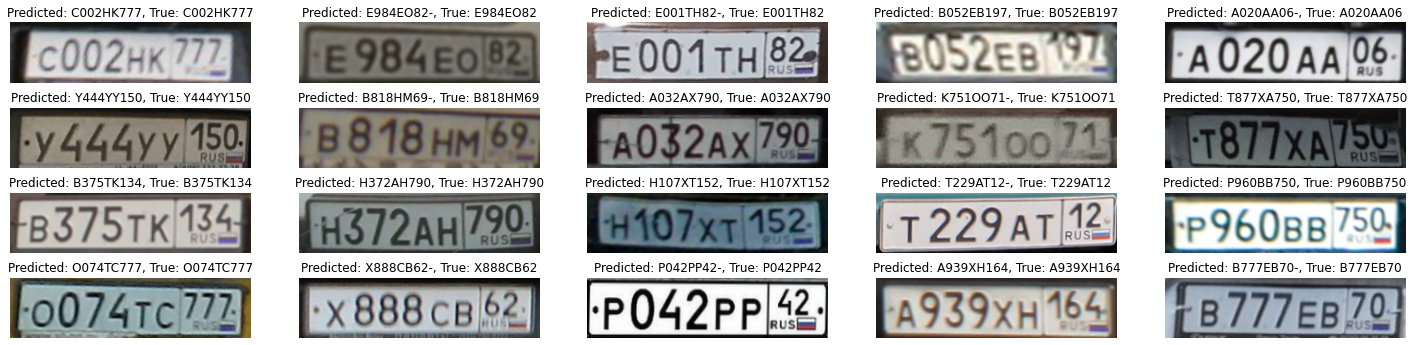

1.0


In [34]:
import random
from random import choices
# random.seed(30)
test_labeled = pd.read_csv('/kaggle/working/test_labeled.csv')
images = test_labeled['image'].tolist()
annotations = test_labeled['annotation'].tolist()
n = 20
samples = choices(list(range(len(images))), k=n)
_images = [images[ind] for ind in samples]
_labels = [annotations[ind] for ind in samples]
    
metric = metrics[0]
# metric.update_state(
#     tf.convert_to_tensor([prepare_label('OO34OO77', label_mapper)]),
#     tf.convert_to_tensor([prepare_label('O034OO77', label_mapper)]))

for index, (sample, ann) in enumerate(zip(_images, _labels)):
    plt.rcParams['figure.figsize'] = (25, 6)
    img = cv2.imread(sample)
    img = cv2.resize(img, (width, heigth))
#     factor = 1.3
#     img_scaled = cv2.resize(img.copy(), (int(width * 1/factor), int(heigth * 1/factor)))
#     img = np.zeros((heigth, width, 3))
#     x = (width - img_scaled.shape[1]) // 2
#     y = (heigth - img_scaled.shape[0]) // 2
#     img[y:y+img_scaled.shape[0],x:x+img_scaled.shape[1]] = img_scaled
    ax = plt.subplot(n // 5 + min(1, n % 5), 5, index+1)
    ax.imshow(img.astype(np.int16))
    plt.axis('off')
    
    logits = model(tf.expand_dims(tf.convert_to_tensor(img), 0), training=False)
    
    metric.update_state(prepare_label(ann, label_mapper), logits)
    
    pred = tf.argmax(logits, -1).numpy()[0]
    label = ''.join([unique_symbols[ind] for ind in pred])
    plt.title(f'Predicted: {label}, True: {ann}')
plt.show()
print(metric.result().numpy())
metric.reset_state()